# Mining Data Streams


## Sampling

- Reservoir
    fixed size
    pick new sample with probability s/n
    replace uniformly, all s samples are equally likely to get replaced

## Filtering
- First cut
    hashed bit array
- Bloom filter
    using n hash functions to verify that x is in S
    optimal k = n/m *ln(2)

## Algorithms on stream
- unique elements
- occurence
    - moments
        - 0 - distinct values
        - 1 - stream length
        - 2 - surprise
        - k - Sum of (m_j)^k = n(c_k - ( c - 1)^k )




implementing: [In-Core Computation of Geometric Centralities with
HyperBall:
A Hundred Billion Nodes and Beyond](https://arxiv.org/pdf/1308.2144v2)
1. Flajolet-Martin algorithm
2. Streaming graph algorithm



HyperLogLog

HyperBall


In [54]:
# HyperLogLog counter

from mmh3 import hash
import math

def _hash(x):
    return hash(x)

def _leading_zeros(x):
    if isinstance(x, bytes):
        # Convert bytes to string and count leading zeros
        return str(x, 'ascii').count('0', 0, str(x, 'ascii').find('1'))
    elif isinstance(x, int):
        # Convert integer to binary string and count leading zeros
        return bin(x)[2:].count('0', 0, bin(x)[2:].find('1'))

    raise ValueError(f"Unsupported type: {type(x)}")

def p_plus_one(x):
    return _leading_zeros(x) + 1

class Counter:
    def __init__(self, b):
        self.p = (2**b)
        self.b = b
        self.M = [0] * self.p
        self.alpha_p = 0.7213 / (1 + 1.079 / self.p) # https://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf p.140 (14)
    
    def set_m(self, m):
        self.M = m
        return self

    def add(self, x, verbose=False):
        h = _hash(str(x).encode('utf-8'))
        # Get bucket index using first b bits
        i = h & ((1 << self.b) - 1)
        # Get remaining bits
        w = h >> self.b
        # count leading zeros
        p = p_plus_one(w)
        self.M[i] = max(self.M[i], p)
        
        if verbose: print(f"h: {h:032b}, i: {i:{self.b}b}, w: {w:{32-self.b}b}, p_+1: {p}, M[i]: {self.M[i]}")


    def size(self):

        Z = sum(2**(-m) for m in self.M)
        E = self.alpha_p * self.p**2 * (1 / Z)
        V = self.M.count(0)
        
        if E <= 5/2 * self.p:
            # Small-range correction using Linear Counting
            if V != 0:
                E = self.p * math.log(self.p / V)
        
        return E
    
    def _repr_(self):
        return f"Counter(b={self.b}, p={self.p}, M={self.M})"
    
    


In [55]:
c = Counter(4)

In [56]:
c.size()

0.0

In [57]:
c.add(500, True)
c.size()


h: 00000110000101001011110011100110, i:  110, w:      11000010100101111001110, p_+1: 1, M[i]: 1


1.0326163382011386

In [58]:
c._repr_()

'Counter(b=4, p=16, M=[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])'

In [59]:
c.add(100)
c.size()


2.136502281992361

In [60]:
c._repr_()

'Counter(b=4, p=16, M=[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])'

The Linear Counting seems to work

In [61]:
from itertools import islice

def process_data(filename, n=None):
    data = []
    with open(filename, 'r') as f:
        # If n is None, islice will read until the end
        for line in islice(f, n):
            if line.strip().startswith('#'):
                continue
            source, target = map(int, line.strip().split())
            data.append((source, target))
    return data
    
class Graph:
    def __init__(self, data):
        self.build(data)
    
    def build(self, data):
        self.adj_list = {}
        self.nodes = set()
        
        # Build the graph
        for source, target in data:
            self.nodes.add(source)
            self.nodes.add(target)
            
            if source not in self.adj_list:
                self.adj_list[source] = set()
            self.adj_list[source].add(target)
            
        # Add node mapping
        self.node_to_idx = {node: idx for idx, node in enumerate(sorted(self.nodes))}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
    
    def neighbors(self, idx):
        """Return neighbors of a node (using internal index)"""
        node = self.idx_to_node[idx]
        return {self.node_to_idx[n] for n in self.adj_list.get(node, set())}
    
    def num_nodes(self):
        """Return total number of nodes"""
        return len(self.nodes)
        
        


In [62]:
data = process_data('data/web-BerkStan.txt', n=50000)

In [63]:

G = Graph(data)


In [64]:


import os

class Disk:
    def __init__(self, path):
        self.path = path
        self.delimiter = '---'
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        
        # create path if doesn't exist
        if not os.path.exists(self.path):
            with open(self.path, 'w') as f:
                f.write('')
        
        self.clear()
    
    def clear(self):
        with open(self.path, 'w') as f:
            f.write('')

    def write_single_vc(self, v, c):
        """Write a single edge to disk"""
        with open(self.path, 'a') as f:
            # Convert list to comma-separated string
            c_str = ','.join(map(str, c))
            f.write(f"{v}{self.delimiter}{c_str}\n")
    
    def read_edges(self):
        """Read edges from disk and return as list of tuples"""
        edges = []
        with open(self.path, 'r') as f:
            for line in f:
                v, c_str = line.strip().split(self.delimiter)
                # Convert string back to list of integers
                c = list(map(int, c_str.split(',')))
                edges.append((int(v), c))
        return edges

def union(a:Counter, b:Counter):
    for i in range(a.p):
        a.M[i] = max(a.M[i], b.M[i])
    return a



In [65]:

# # HyperBall algorithm
# D = Disk('tmp/counts.txt')
# B = 4
# N = G.num_nodes()
# MAX_STEPS = 100

# # intialize counters
# c = [Counter(B) for _ in range(N)]

# # add self to each counter
# for v in range(N):
#     c[v].add(v)
    

# # history
# counter_sizes_t = []

# t = 0   
# while t < MAX_STEPS:
#     counter_sizes_t.append([c[v].size() for v in range(N)])

#     for v in range(N):
#         a = c[v]
#         for w in G.neighbors(v):
#             a = union(c[w], a)
        
#         # write to disk
#         D.write_single_vc(v, a.M)
    
#     # read from disk
#     vms = D.read_edges()
#     D.clear()
    
#     # update counters if changed
#     changed = False
#     for v, m in vms:

#         if c[v].M != m:
#             c[v].set_m(m)
#             changed = True
        
    
    
#     if not changed:
#         break
#     t += 1


In [71]:
from tqdm import tqdm

# HyperBall algorithm
def hyperball(G, B=4, MAX_STEPS=100, use_disk=False):
    D = Disk('tmp/counts.txt') if use_disk else None
    N = G.num_nodes()
    
    # initialize counters
    c = [Counter(B) for _ in range(N)]
    for v in range(N):
        c[v].add(v)
    
    # history
    counter_sizes_t = []
    
    for t in tqdm(range(MAX_STEPS), desc="HyperBall"):
        counter_sizes_t.append([c[v].size() for v in range(N)])
        
        if use_disk:
            # Disk-based version
            for v in range(N):
                a = c[v]
                for w in G.neighbors(v):
                    a = union(c[w], a)
                D.write_single_vc(v, a.M)
            
            vms = D.read_edges()
            D.clear()
            
            # update counters if changed
            changed = False
            for v, m in vms:
                if c[v].M != m:
                    c[v].set_m(m)
                    changed = True
        else:
            # In-memory version
            new_counters = []
            changed = False
            
            for v in range(N):
                a = Counter(B)
                a.set_m(c[v].M.copy())  # Start with current counter
                for w in G.neighbors(v):
                    a = union(c[w], a)
                new_counters.append(a)
                
                if a.M != c[v].M:
                    changed = True
            
            c = new_counters
            
        if not changed:
            print(f"Converged at step {t}")
            break
    
    return c, counter_sizes_t

data = process_data('data/web-BerkStan.txt',)
G = Graph(data)
c, counter_sizes_t = hyperball(G, B=5, MAX_STEPS=100, use_disk=False)


HyperBall:  55%|█████▌    | 55/100 [23:05<18:53, 25.18s/it]

Converged at step 55


In [72]:
G.num_nodes()

685230

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperball_evolution(counter_sizes_t):
    # Plot individual node trajectories
    plt.figure(figsize=(12, 6))
    num_nodes = len(counter_sizes_t[0])
    
    for node in range(num_nodes):
        node_sizes = [sizes[node] for sizes in counter_sizes_t]
        plt.plot(node_sizes, alpha=0.3, 
                 label=f'Node {node}' if node < 5 else "")

    plt.xlabel('Time Step (t)')
    plt.ylabel('Counter Size')
    plt.title('HyperBall Counter Sizes Evolution Over Time')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot average trajectory
    plt.figure(figsize=(12, 6))
    avg_sizes = [np.mean(sizes) for sizes in counter_sizes_t]
    plt.plot(avg_sizes, 'r-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Counter Size')
    plt.title('Average HyperBall Counter Size Evolution Over Time')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    # Calculate changes between consecutive steps
    avg_changes = [abs(avg_sizes[i+1] - avg_sizes[i]) for i in range(len(avg_sizes)-1)]
    
    plt.plot(avg_changes, 'b-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Change')
    plt.title('Average Change in Counter Size Between Steps')
    plt.grid(True)
    plt.yscale('log')  # Using log scale as changes might vary by orders of magnitude
    plt.show()
    

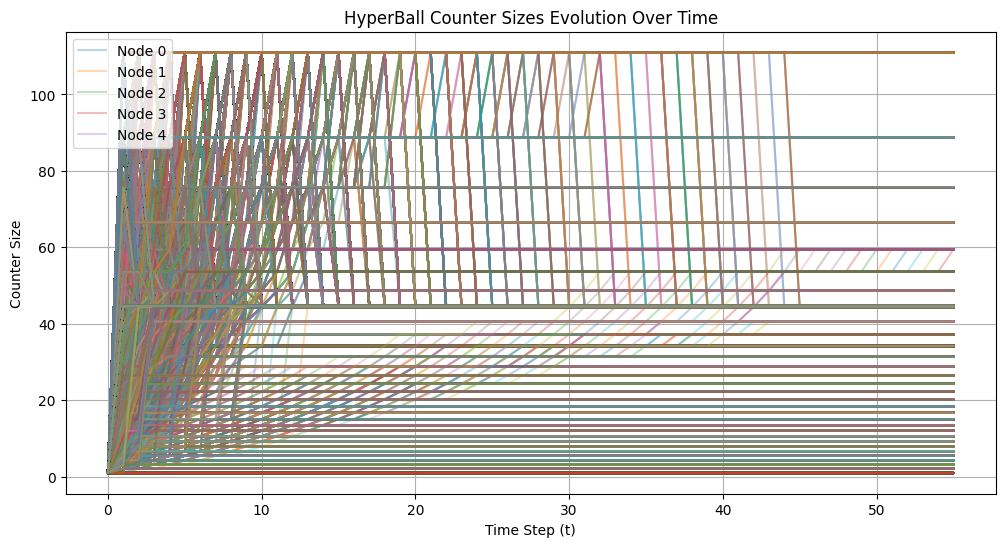

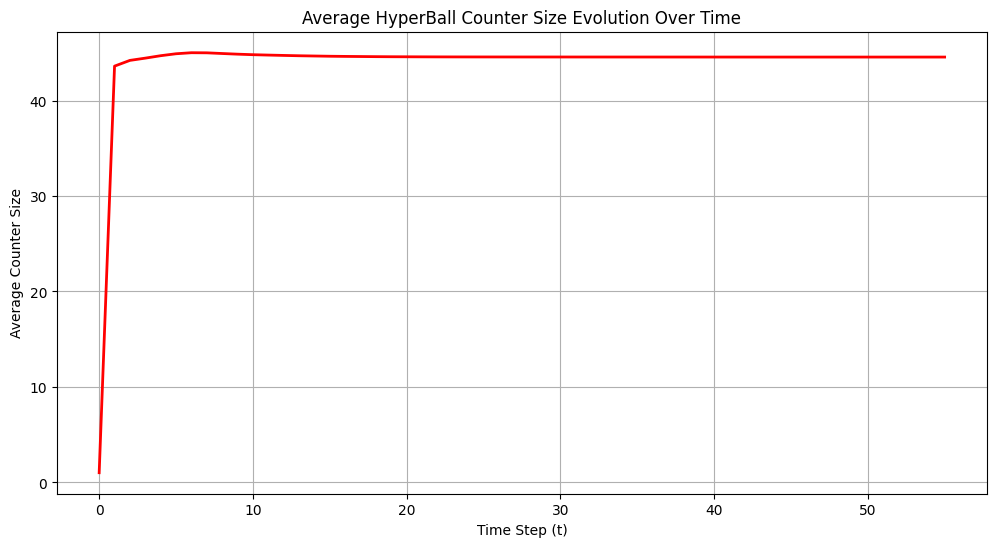

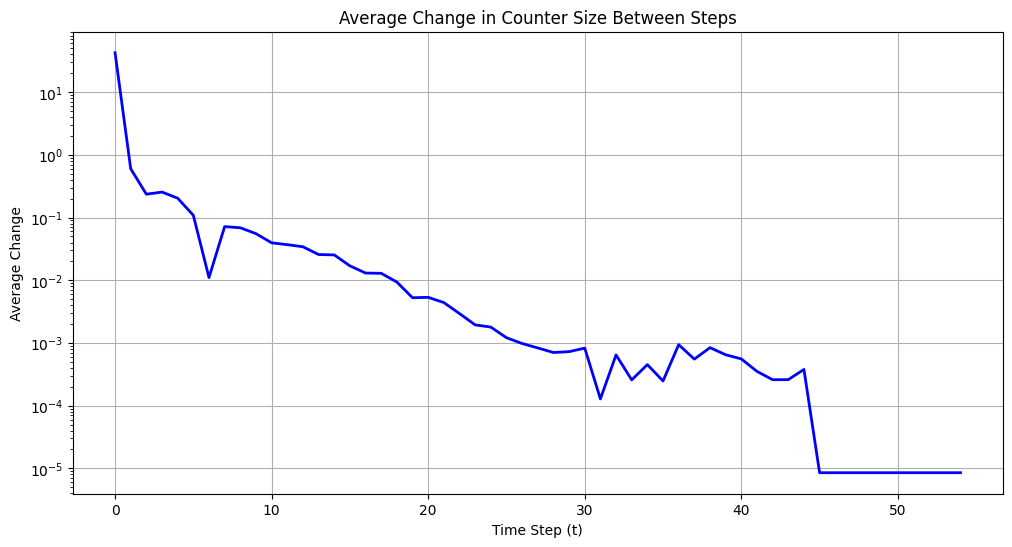

In [74]:
plot_hyperball_evolution(counter_sizes_t)

In [126]:
G.num_nodes()

473715

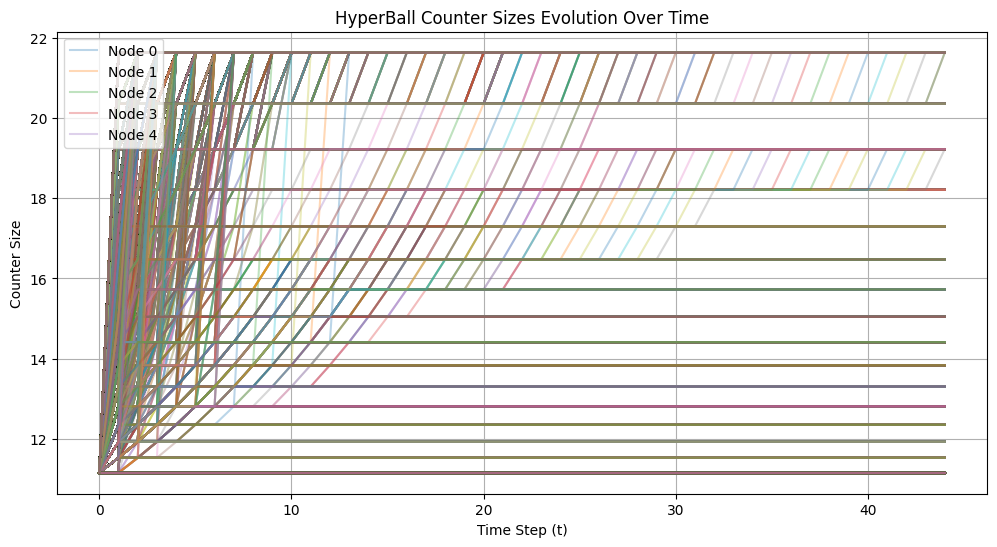

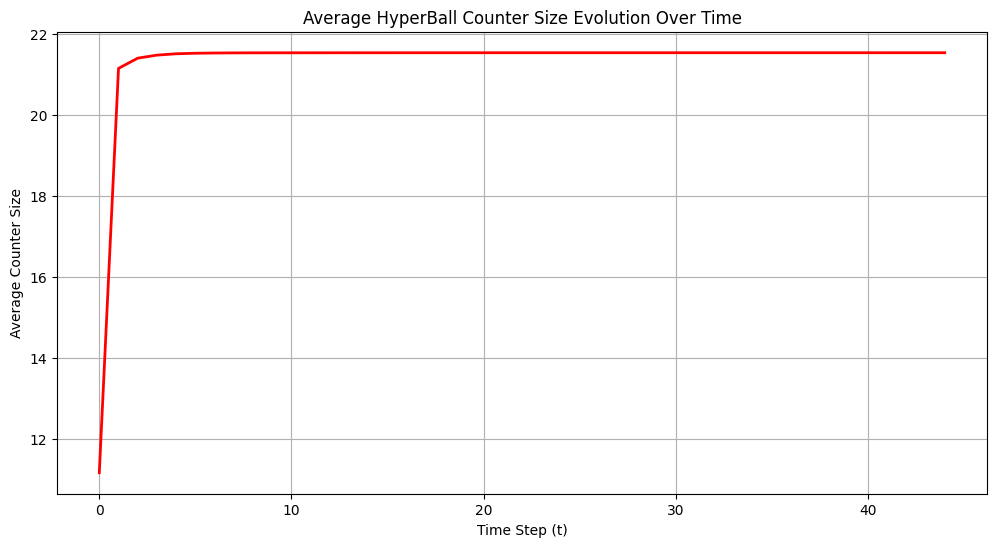

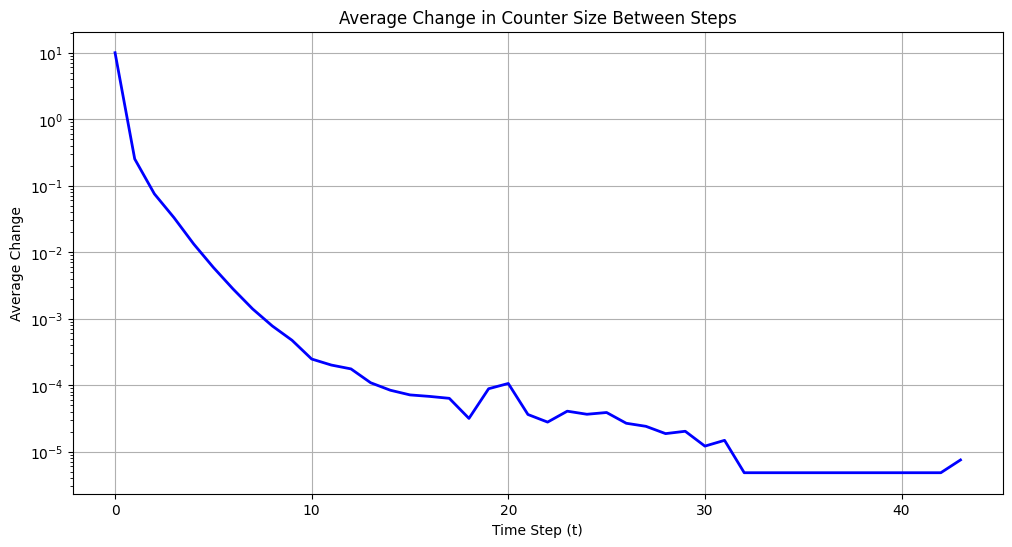

In [127]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperball_evolution(counter_sizes_t):
    # Plot individual node trajectories
    plt.figure(figsize=(12, 6))
    num_nodes = len(counter_sizes_t[0])
    
    for node in range(num_nodes):
        node_sizes = [sizes[node] for sizes in counter_sizes_t]
        plt.plot(node_sizes, alpha=0.3, 
                 label=f'Node {node}' if node < 5 else "")

    plt.xlabel('Time Step (t)')
    plt.ylabel('Counter Size')
    plt.title('HyperBall Counter Sizes Evolution Over Time')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot average trajectory
    plt.figure(figsize=(12, 6))
    avg_sizes = [np.mean(sizes) for sizes in counter_sizes_t]
    plt.plot(avg_sizes, 'r-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Counter Size')
    plt.title('Average HyperBall Counter Size Evolution Over Time')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    # Calculate changes between consecutive steps
    avg_changes = [abs(avg_sizes[i+1] - avg_sizes[i]) for i in range(len(avg_sizes)-1)]
    
    plt.plot(avg_changes, 'b-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Change')
    plt.title('Average Change in Counter Size Between Steps')
    plt.grid(True)
    plt.yscale('log')  # Using log scale as changes might vary by orders of magnitude
    plt.show()
    

plot_hyperball_evolution(counter_sizes_t)

# Bonus Points

1. What were the challenges you faced when implementing the algorithm?

The main issue faced was to evaluate the algorithm and know that it is doing what it should. It's important to set b properly so that the counters are able to count in the appropriate range. e.g. b=4 ranges 11-22. To resolve this, plots to see the evolution of the algorithm was used. I still don't know if this is the proper result, however it seems reasonable and eventually converges. There's also a computing issue combined with precision, increasing b exponentially increases the compute. 

2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain

Yes, the Hyberball algorithm is parallelizable. 

The key to parallelizing Hyberball lies in the fact that each node's computation at iteration t depends only on known counts from iteration t-1. Thus, there's no need for nodes to wait on each other's updates within the same iteration. By distributing the workload and ensuring proper synchronization between iterations, we can achieve significant performance improvements, especially on large graphs.

In more detail, for each iteration, the counters gets merged by their unions. The union operator is commutable, thus it doesn't matter in which order this is done. 

Hyberball involves merging neighbouring nodes. The implemented version here doesn't use the fact that the result of a merge could be applied to the neighbouring node as well (if the edge is bidirectional). So as is, the algorithm can be easily parallelized where the compute for each node is distributed among the available resources.

Each iteration needs to be synced for next iteration. So that the merged counts are used in the next iteration.
The cores could fetch nodes from a pool of nodes to be computed, and then when there's no more nodes left. All cores sync their results, and continues to next iteration. 

3. Does the algorithm work for unbounded graph streams? Explain.

No. The implemented version of the Hyberball algorithm uses a static graph. The semi-streamed fashion described in the paper is streaming adjacency lists for each node, which is done current implementation. Thus the implemented version doesn't work for unbounded graphs. The implemented version could be modified to dynamically adjust the adjacency lists by reading more of the graph stream. 

4. Does the algorithm support edge deletions? If not, what modification would it need? Explain

The main issue is that the HyperLogLog counters used in Hyberball are designed for cardinality estimation through union operations. Which support adding elements (union) but not removing them. Once an element is added to a counter, it cannot be efficiently removed or decremented.

So even if we modify the algorithm to support streaming a dynamic graph, the counters don't support the edge deletion. 
